# Fraud Detection using Variational AutoEncoder

1. Raw Dataset
2. Visualize Preprocessed Transaction Features
3. Train a Variational Autoencoder
4. Visualize Latent Representations
5. VAE vs SVM
6. Evaluation on Test Set
7. Limitations

Source: https://www.kaggle.com/code/hone5com/fraud-detection-with-variational-autoencoder

**[ Updated code to work with tf version 2.16 ]**

### Environment Setup:

In [ ]:
# Run only if needed
!pip install -q --upgrade tf-nightly #==2.10 #1.14.1-dev20190312 #tf-nightly-gpu==1.14.1-dev20190312
!pip install -q --upgrade tfp-nightly #==0.16 # #==0.7.0.dev20190312

In [ ]:
!pip install -q --upgrade tf_keras
!pip install -q --upgrade tensorflow

In [ ]:
!pip install -q --upgrade tensorflow-hub

In [ ]:
tf.__version__, tf_keras.__version__

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
    import tensorflow.compat.v2 as tf
    tf.enable_v2_behavior()
    assert tf2.enabled()

# import tensorflow_datasets as tfds
import tensorflow_probability as tfp

# tfk = tf.keras
import tf_keras as tfk
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import os

%matplotlib inline
np.random.seed(0)
tf.random.set_seed(0)
print(tf.__version__)
print(tfp.__version__)

2.16.1
0.24.0


In [9]:
### Utility Functions
## Plots
# Plot Feature Projection [credit: https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders]
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
#     plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud', s=2)
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud', s=2)

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show()
    
# Plot Keras training history
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log',base=10)
    plt.show()

### Preprocessing Credit Card dataset:

Upload creditcard.csv as Input and use the folder path /kaggle/input/creditcardfrauddetection/creditcard.csv 

In [10]:
raw_data = pd.read_csv("/kaggle/input/creditcardfrauddetection/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

In [11]:
raw_data[raw_data.Class == 1]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


Time field in seconds elapsed is to 24 hour window. 
Amount field is transformed to log scale to reflect magnitude of a transaction than linear amounts.

In [12]:
data.loc[:,"Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.loc[:,'Amount'] = np.log(data['Amount']+1)

data_test.loc[:,"Time"] = data_test["Time"].apply(lambda x : x / 3600 % 24)
data_test.loc[:,'Amount'] = np.log(data_test['Amount']+1)
# data = data.drop(['Amount'], axis = 1)
print(data.shape)
data.head()

(213605, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
194763,12.318611,2.047163,0.107987,-1.806515,0.072733,0.248371,-1.744837,0.712448,-0.488842,-0.102709,...,0.241017,0.822618,0.023000,0.549868,0.322173,0.191755,-0.085025,-0.084292,0.570980,0
135660,22.595556,1.282404,0.459864,-0.372286,0.826375,0.463568,-0.466407,0.460867,-0.186469,-0.549700,...,0.013986,0.083896,-0.247504,-0.325527,0.927293,-0.272555,-0.010168,-0.005332,1.026042,0
259186,20.167778,-0.414863,0.012026,1.356386,1.107374,0.813456,-0.156497,-0.372675,0.031095,-0.100143,...,-0.052272,-0.088160,0.062521,-0.680805,-0.641474,-0.159995,0.237628,0.204343,1.938742,0
87387,17.128333,-1.432948,1.478076,0.576724,0.207540,-0.670662,-0.464572,0.221023,-0.099811,1.561896,...,-0.055014,0.364330,0.154670,0.635611,-0.366314,0.163690,-0.750285,-0.275117,2.322388,0
267282,21.195278,2.051016,-0.016765,-2.284865,0.302168,0.786895,-0.998558,0.768990,-0.464383,0.362863,...,0.133331,0.491780,-0.119020,0.527179,0.607105,-0.090453,-0.065787,-0.062680,3.882182,0


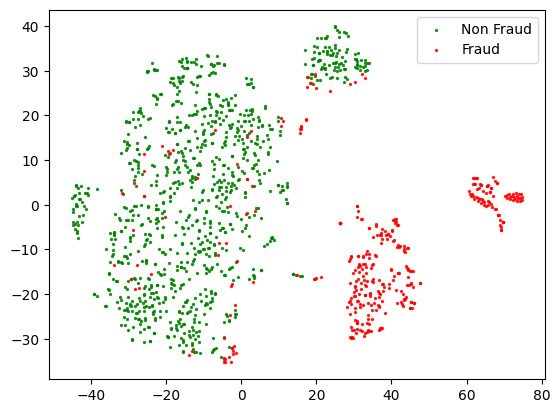

In [28]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = pd.concat([non_fraud, fraud]).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

tsne_plot(X, Y, "original.png")

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 8)                 918       
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 multivariate_normal_tri_l   ((None, 2),               0         
 (MultivariateNormalTriL)     (None, 2))                         
                                                                 
Total params: 963 (3.76 KB)
Trainable params: 963 (3.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 20)                334       
            

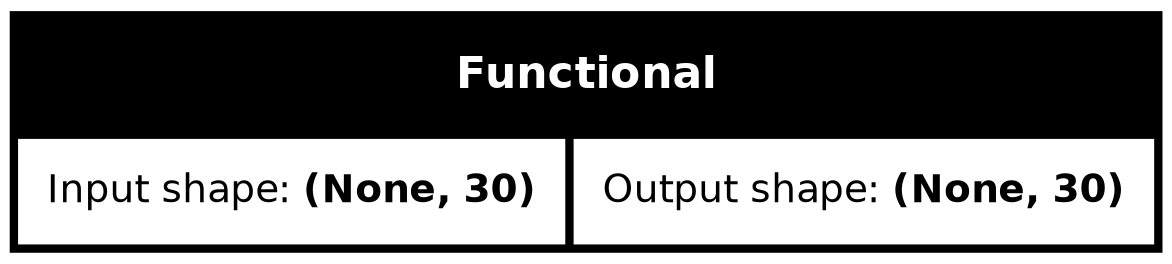

In [16]:
def dense_layers(sizes):
    return tfk.Sequential([tfk.layers.Dense(size, activation=tf.nn.leaky_relu) for size in sizes])

original_dim = X.shape[1]
input_shape = X[0].shape
intermediary_dims = [20, 10, 8]
latent_dim = 2
batch_size = 128
max_epochs = 100

# prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dim), scale=1),
#                         reinterpreted_batch_ndims=1)

prior = tfd.MultivariateNormalDiag(loc=tf.zeros([latent_dim])) #, scale_identity_multiplier=1.0)

encoder = tfk.Sequential([
    tfk.layers.InputLayer(input_shape=input_shape, name='encoder_input'),
    dense_layers(intermediary_dims),
    tfk.layers.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),
    tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),], name='encoder')

encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

decoder = tfk.Sequential([
    tfk.layers.InputLayer(input_shape=[latent_dim]),
    dense_layers(reversed(intermediary_dims)),
    tfk.layers.Dense(tfpl.IndependentNormal.params_size(original_dim), activation=None),
    tfpl.IndependentNormal(original_dim),], name='decoder')

decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]),
                name='vae_mlp')

negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tfk.optimizers.Nadam(), loss=negloglik)

vae.summary()
plot_model(vae, to_file='vae_mlp.png', show_shapes=True)

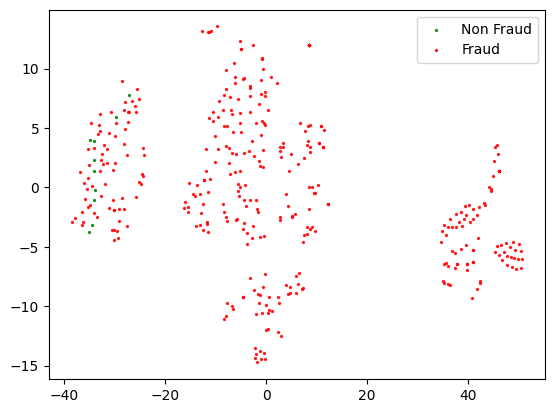

In [17]:
non_fraud = data[data['Class'] == 0].sample(10)
fraud = data[data['Class'] == 1]

df = pd.concat([non_fraud, fraud]).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

tsne_plot(X, Y, "original.png")

## Variational AutoEncoder

We train a VAE with 100k in-sample non-fraud transactions. As this is for exploratory and illustration purpose, the hidden layer design was by trial and error.

The prior for the latent variables was set to be a random unit multivariate normal vector of the latent dimension. The latent dimension is set to 2 so that it give some intuitive illustrations as you will see soon.

The output of the encoder, the latent distribution parameters, was deliberately chosen to be multiviarate normal with non-zero covariance because I noticed it had subsequent impact on the separation of normal transactions from fraud transactions, suggesting that the covariance of fraud transactions may have patterns. As a result, there are 5 distribution parameters to be learnt (2 mean values + 3 covariance values from the lower triangle of the 2-buy-2 covariance matrix)

The output of the decoder, the data distribution parameters, follow feature-independent normal distributions. This choice is important. Most of the examples I could find online were applied to binary images such as the MNIST dataset where the output would follow independent bernoulli distributions. Here the data are real-valued and generally follow normal distributions, hence it only makes sense to model the output with normal distributions or alike. Another important implication of having the right distribution is that it will give the corresponding log probability loss during training. It would not make sense to train a real-valued normal distribution using binary cross entropy, for example.

In [18]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_norm, x_fraud = x.values[y == 0], x.values[y == 1]

x_norm_sample = x_norm[np.random.randint(x_norm.shape[0], size=100000), :]
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample, test_size=0.2)

In [19]:
tf_train = tf.data.Dataset.from_tensor_slices((x_norm_train_sample, x_norm_train_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))
tf_val = tf.data.Dataset.from_tensor_slices((x_norm_val_sample, x_norm_val_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))

In [20]:
checkpointer = ModelCheckpoint(filepath='bestmodel.keras', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)

hist = vae.fit(tf_train,
               epochs=max_epochs,
               shuffle=True,
               verbose=1,
               validation_data=tf_val,
               callbacks=[])

Epoch 1/100


I0000 00:00:1724398664.911928     145 service.cc:145] XLA service 0x7889e253cf00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724398664.911996     145 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1724398665.120094     145 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - 32s 9ms/step - loss: 341.4021 - val_loss: 82.9142
Epoch 2/100
625/625 [==============================] - 4s 7ms/step - loss: 74.6691 - val_loss: 64.6077
Epoch 3/100
625/625 [==============================] - 5s 7ms/step - loss: 62.1288 - val_loss: 67.8225
Epoch 4/100
625/625 [==============================] - 4s 7ms/step - loss: 57.0992 - val_loss: 55.9525
Epoch 5/100
625/625 [==============================] - 4s 7ms/step - loss: 52.5360 - val_loss: 52.1418
Epoch 6/100
625/625 [==============================] - 4s 7ms/step - loss: 51.1118 - val_loss: 49.5895
Epoch 7/100
625/625 [==============================] - 4s 7ms/step - loss: 48.0522 - val_loss: 47.6499
Epoch 8/100
625/625 [==============================] - 4s 7ms/step - loss: 46.5760 - val_loss: 46.1806
Epoch 9/100
625/625 [==============================] - 4s 7ms/step - loss: 44.9941 - val_loss: 45.0744
Epoch 10/100
625/625 [==============================] - 5s 7ms/step - loss: 44.1877

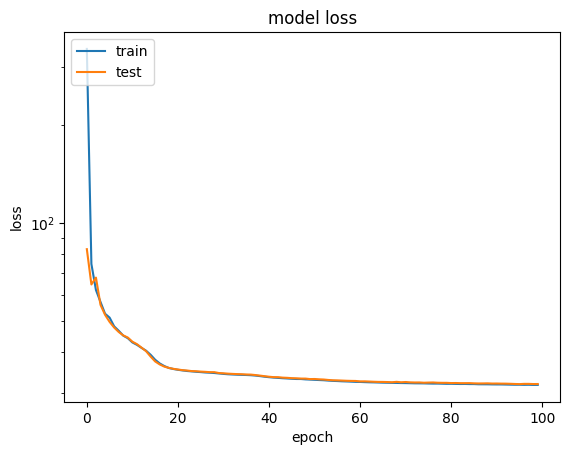

In [21]:
plot_loss(hist)

The training stops when the validation losses fail to decrease for 20 consecutive epochs.

Define a function that would perform Monte Carlo on inputs to compute the reconstruction probability (given the output data distribution, what would be the probability to generate the original input?). I sample 100 times for each input.

## 4. Visualize Latent Representations¶
T-SNE plots of latent distribution parameters and samples for the previously sampled data. Notice how the clustering are very pronounced across all plots.

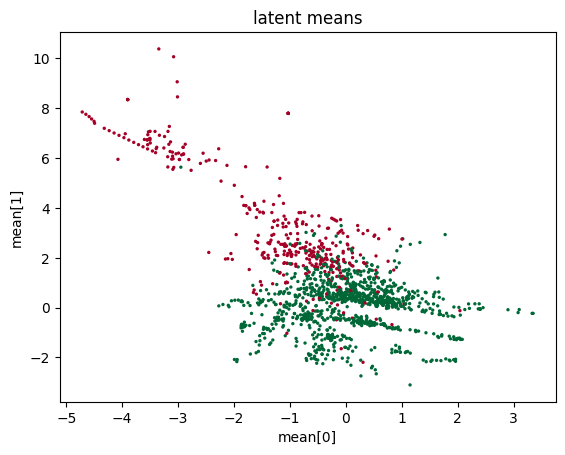

In [29]:
latent_x_mean = encoder(X).mean()
plt.scatter(latent_x_mean[:, 0], latent_x_mean[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent means')
plt.ylabel('mean[1]')
plt.xlabel('mean[0]')
plt.show()

If there is a clear separation between the fraud and non-fraud transactions around the origin [0,0] mean vector, a sign that the VAE is learning something meaningful.

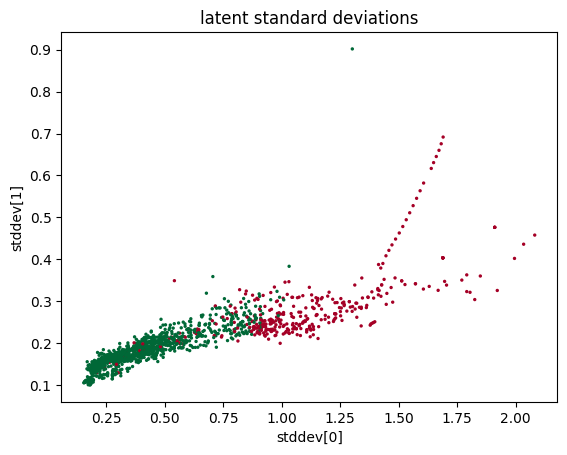

In [30]:
latent_x_std = encoder(X).stddev()
plt.scatter(latent_x_std[:, 0], latent_x_std[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent standard deviations')
plt.ylabel('stddev[1]')
plt.xlabel('stddev[0]')
plt.show()

Notice how the fraud transactions's standard deviations in red are much more scattered and tend to have higher values in both axes. This is inline with the intuition that fraud transactions tend to be erratic.

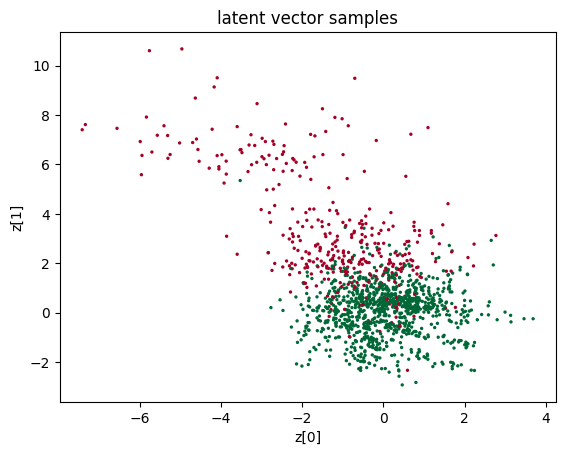

In [31]:
latent_x = encoder(X).sample()
plt.scatter(latent_x[:, 0], latent_x[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent vector samples')
plt.ylabel('z[1]')
plt.xlabel('z[0]')
plt.show()

The sampled latent vector z. The clustering and scattering are consistent with previous observations.

In [32]:
reconstruct_samples_n = 100

def reconstruction_log_prob(eval_samples, reconstruct_samples_n):
    encoder_out = encoder(eval_samples)
    print(encoder_out.shape)
    #encoder_samples = encoder_out.sample(reconstruct_samples_n)
    return decoder(encoder_out).log_prob(eval_samples)
    #return np.mean(decoder(encoder_out).log_prob(eval_samples), axis=0)

(1372, 2)


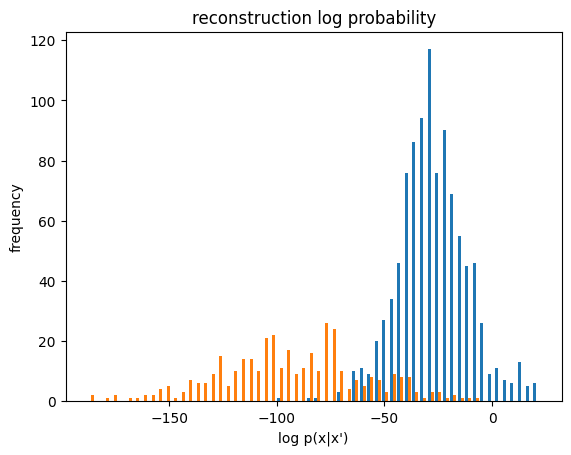

In [33]:
x_log_prob = reconstruction_log_prob(X, reconstruct_samples_n)
ax = plt.hist([x_log_prob[Y==0], x_log_prob[Y==1]], 60)
plt.title('reconstruction log probability')
plt.ylabel('frequency')
plt.xlabel("log p(x|x')")
plt.show()

Looking at the log of the reconstruction probability, fraud transactions in orange are clearly separeted from normal transaction in most cases despite some overlaps. Normal transactions have higher reconstruction probability, of course.

Now, let's take the negative reconstruction log probability, and draw a ROC curve across the range to see how it would perform if we were to build a threshold-based fraud detector on it.

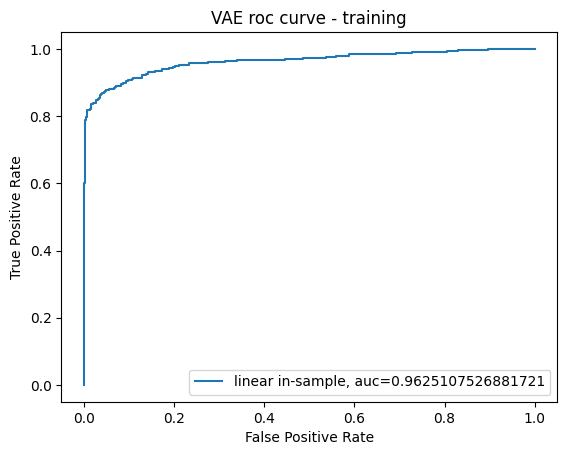

In [34]:
fpr, tpr, thresh = roc_curve(Y, -x_log_prob)
auc = roc_auc_score(Y, -x_log_prob)

plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('VAE roc curve - training')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

Above 0.96 in training set, pretty decent!

## 5. VAE vs SVM
Let's compare this with a trivial supervised SVM classifier. I am curious if SVM would outperform VAE, since the preprocessed input seemed to give good separation between frauds and non-frauds. Turns out it did not. VAE for the win!

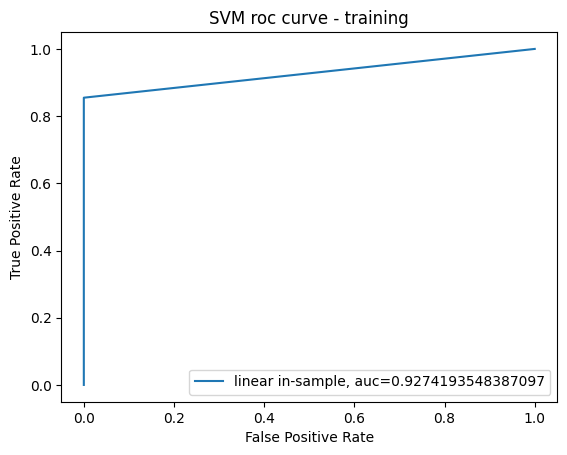

In [35]:
from sklearn import svm
clf = svm.SVC(gamma='scale')
clf.fit(X, Y)
fpr, tpr, thresh = roc_curve(Y, clf.predict(X))
auc = roc_auc_score(Y, clf.predict(X))

plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('SVM roc curve - training')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

## 6. Evaluation on Test Set
Evaluate VAE and a trivial SVM on the previously reserved test set. VAE outperforms the simple SVM.

(71202, 2)


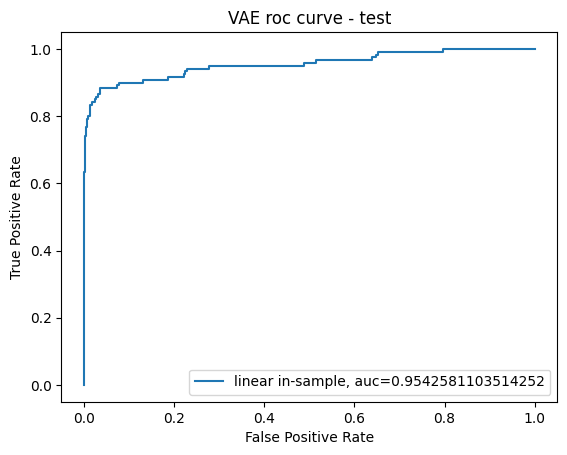

In [36]:
x_test_log_prob = reconstruction_log_prob(data_test.drop(['Class'], axis = 1).values, reconstruct_samples_n)
test_y = data_test["Class"].values

fpr, tpr, thresh = roc_curve(test_y, -x_test_log_prob)
auc = roc_auc_score(test_y, -x_test_log_prob)

plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('VAE roc curve - test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

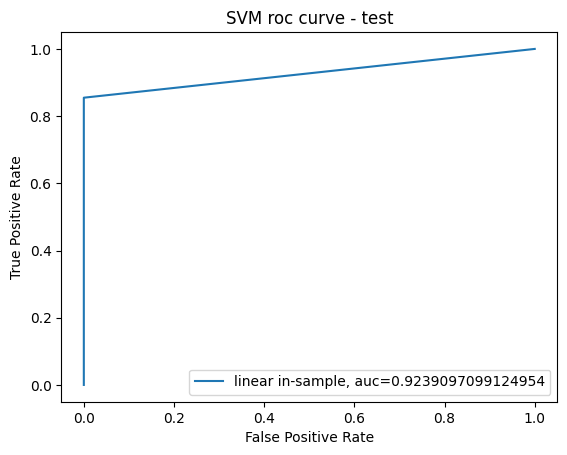

In [38]:
auc = roc_auc_score(test_y, clf.predict(data_test.drop(['Class'], axis = 1).values))
fpr, tpr, thresh = roc_curve(Y, clf.predict(X))
plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('SVM roc curve - test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()